In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from geopy.distance import vincenty
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
geolocator = Nominatim()
%matplotlib inline

In [2]:
def rmsle(predicted, actual):
    sum = 0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x] + 1)
        r = np.log(actual[x] + 1)
        sum = sum + (p - r) ** 2
    return (sum / len(predicted)) ** 0.5

In [3]:
train = pd.read_csv('C:\Users\Steven\Documents\Git\personal_projects\NewYorkTaxiTripDuration\\train.csv', parse_dates = True)
test = pd.read_csv('C:\Users\Steven\Documents\Git\personal_projects\NewYorkTaxiTripDuration\\test.csv', parse_dates = True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [5]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [8]:
train.describe() #duration is in seconds

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [10]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


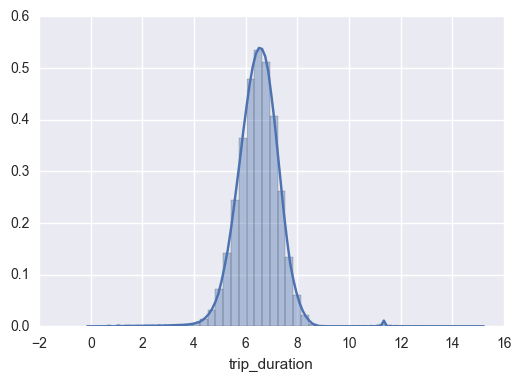

In [11]:
sns.distplot(np.log(train['trip_duration']))

In [12]:
#train = train[(np.abs(stats.zscore(train)) < 3).all(axis = 1)]
#train.info()

In [13]:
train['trip_duration'] = np.log(train['trip_duration'])

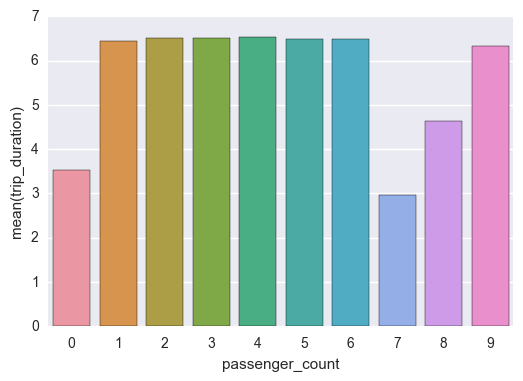

In [14]:
sns.barplot(x = 'passenger_count', y = 'trip_duration', n_boot = 0, data = train)

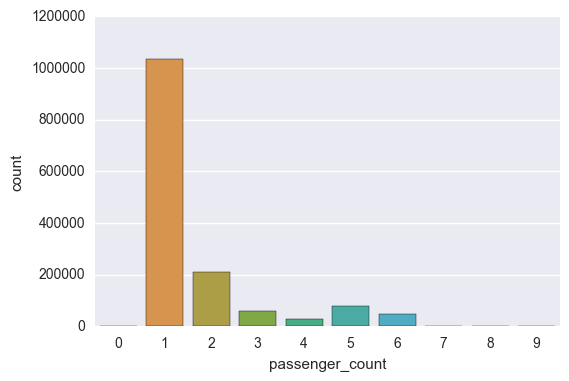

In [15]:
sns.countplot(x = 'passenger_count', data = train)

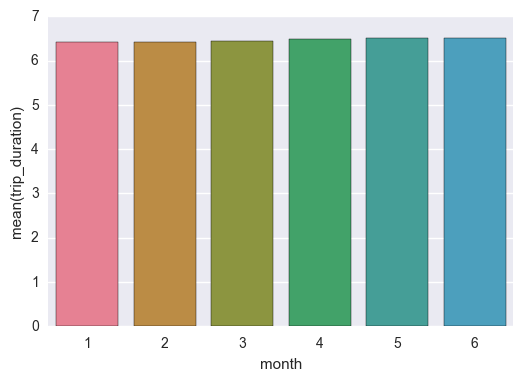

In [16]:
train['month'] = train['pickup_datetime'].apply(lambda x: x.month)
test['month'] = test['pickup_datetime'].apply(lambda x: x.month)

with sns.color_palette('husl', 8):
    sns.barplot(x = 'month', y = 'trip_duration', n_boot = 0, data = train)

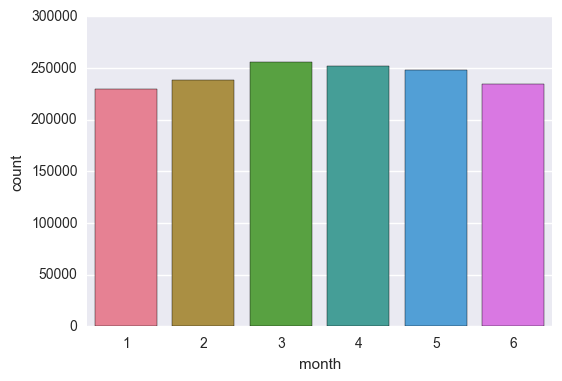

In [17]:
with sns.color_palette('husl'):
    sns.countplot(x = 'month', data = train)

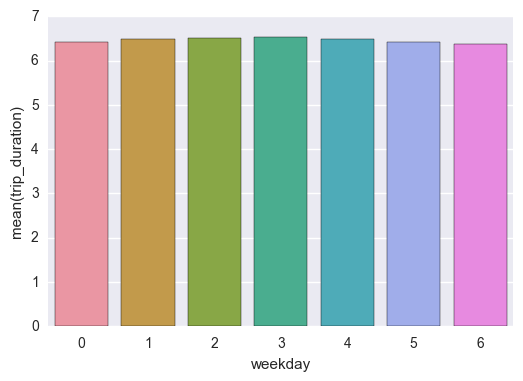

In [18]:
train['weekday'] = train['pickup_datetime'].apply(lambda x: x.weekday())
test['weekday'] = test['pickup_datetime'].apply(lambda x: x.weekday())

sns.barplot(x = "weekday", y = "trip_duration", n_boot = 0, data = train)

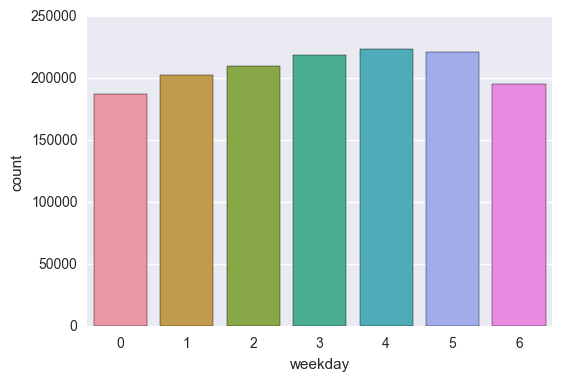

In [19]:
sns.countplot('weekday', data = train)

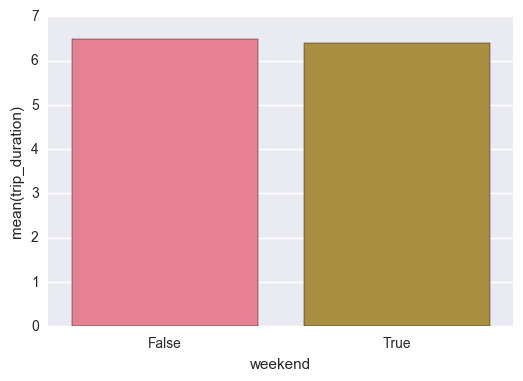

In [20]:
train['weekend'] = train['weekday'] >= 5 * 1
test['weekend'] = test['weekday'] >= 5 * 1

with sns.color_palette('husl'):
    sns.barplot(x = "weekend", y = "trip_duration", n_boot = 0, data = train)

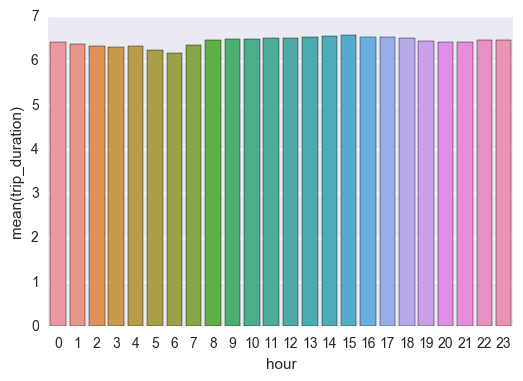

In [21]:
train['hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
test['hour'] = test['pickup_datetime'].apply(lambda x: x.hour)

sns.barplot(x = "hour", y = "trip_duration", n_boot = 0, data = train)

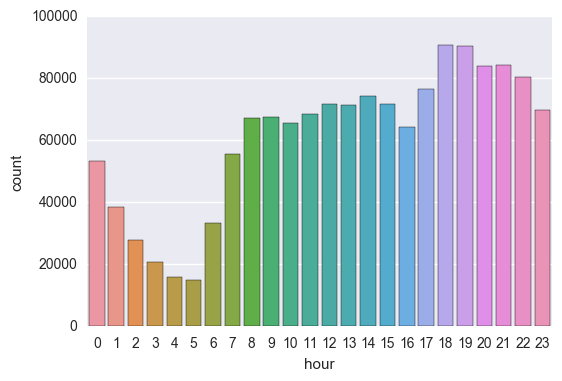

In [22]:
sns.countplot(x = 'hour', data = train)

In [23]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'] == 'Y' * 1
test['store_and_fwd_flag'] = test['store_and_fwd_flag'] == 'Y' * 1

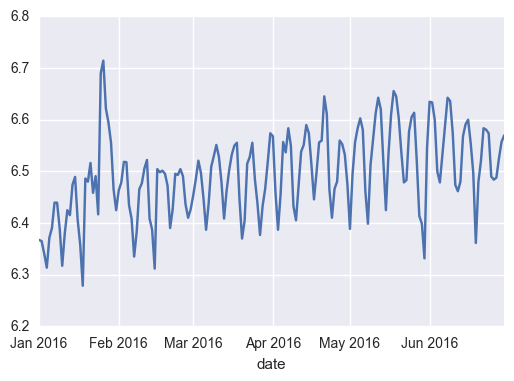

In [24]:
train['date'] = train['pickup_datetime'].dt.date
test['date'] = test['pickup_datetime'].dt.date
train['trip_duration'].groupby(train['date']).median().plot()

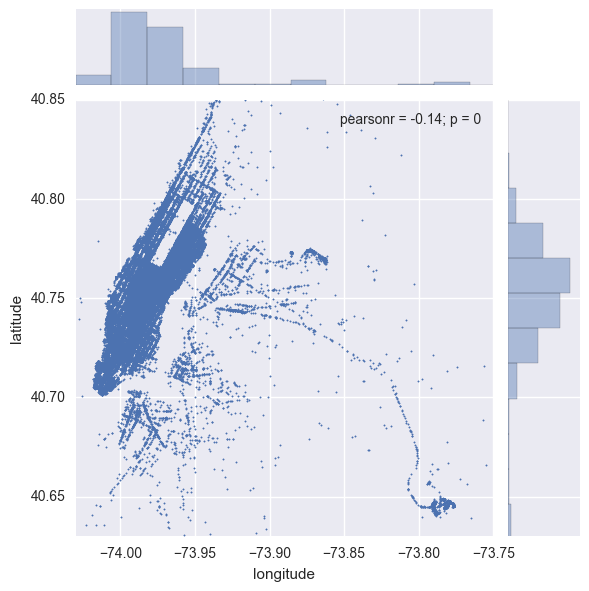

In [25]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

sns.jointplot(x = 'pickup_longitude', y = 'pickup_latitude', data = train.loc[:100000,:], kind = 'scatter', xlim = city_long_border, ylim = city_lat_border, s = 1).set_axis_labels('longitude', 'latitude')

In [26]:
train['pickup_coord'] = list(zip(train['pickup_latitude'], train['pickup_longitude']))
train['dropoff_coord'] = list(zip(train['dropoff_latitude'], train['dropoff_longitude']))
train['distance'] = [vincenty(a, b).miles for a, b in zip(train['pickup_coord'], train['dropoff_coord'])]

test['pickup_coord'] = list(zip(test['pickup_latitude'], test['pickup_longitude']))
test['dropoff_coord'] = list(zip(test['dropoff_latitude'], test['dropoff_longitude']))
test['distance'] = [vincenty(a, b).miles for a, b in zip(test['pickup_coord'], test['dropoff_coord'])]

In [27]:
#warning: slow

kmeans = KMeans(n_clusters = 10, random_state = 1)
kmeans.fit(train[['pickup_longitude', 'pickup_latitude']])
train['pickup_cluster'] = kmeans.labels_

kmeans = KMeans(n_clusters = 10, random_state = 1)
kmeans.fit(test[['pickup_longitude', 'pickup_latitude']])
test['pickup_cluster'] = kmeans.labels_

kmeans = KMeans(n_clusters = 10, random_state = 1)
kmeans.fit(train[['dropoff_longitude', 'dropoff_latitude']])
train['dropoff_cluster'] = kmeans.labels_

kmeans = KMeans(n_clusters = 10, random_state = 1)
kmeans.fit(test[['dropoff_longitude', 'dropoff_latitude']])
test['dropoff_cluster'] = kmeans.labels_

In [28]:
train['same_cluster'] = train['pickup_cluster'] = train['dropoff_cluster'] * 1
test['same_cluster'] = test['pickup_cluster'] = test['dropoff_cluster'] * 1

In [29]:
location = geolocator.reverse(train['pickup_coord'][1])
print location.raw.get('address').get('postcode')

10010


In [30]:
#train['location'] = train['pickup_coord'].apply(lambda x: geolocator.reverse(x)) #warning: slow

In [31]:
del train['id']
del train['pickup_datetime']
del train['dropoff_datetime']
del train['date']
del train['pickup_coord']
del train['dropoff_coord']

del test['pickup_datetime']
del test['date']
del test['pickup_coord']
del test['dropoff_coord']

train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,weekday,weekend,hour,distance,pickup_cluster,dropoff_cluster,same_cluster
0,2,1,-73.982155,40.767937,-73.964630,40.765602,False,6.120297,3,0,False,17,0.933406,0,0,0
1,1,1,-73.980415,40.738564,-73.999481,40.731152,False,6.496775,6,6,True,0,1.123849,2,2,2
2,2,1,-73.979027,40.763939,-74.005333,40.710087,False,7.661056,1,1,False,11,3.964154,2,2,2
3,2,1,-74.010040,40.719971,-74.012268,40.706718,False,6.061457,4,2,False,19,0.921886,2,2,2
4,2,1,-73.973053,40.793209,-73.972923,40.782520,False,6.075346,3,5,True,13,0.737591,0,0,0


In [32]:
X, y = train.drop('trip_duration', axis = 1), train['trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [33]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
predictions = linreg.predict(X_test)

print np.sqrt(metrics.mean_squared_error(y_test, predictions))

0.692739509984


In [34]:
print train.shape
print test.shape

(1458644, 16)
(625134, 16)


In [35]:
id = test['id']
del test['id']

In [36]:
result = linreg.predict(test)
result = pd.DataFrame(abs(result), columns = ['trip_duration'])
result = pd.concat([id, pd.DataFrame(result)], axis = 1, join_axes = [id.index])
result['trip_duration'] = np.exp(result['trip_duration'])
result.head()

,id,trip_duration
0,id3004672,728.562702
1,id3505355,727.443175
2,id1217141,576.714275
3,id2150126,941.461643
4,id1598245,624.830449


In [39]:
#save predictions to csv file for submissions

result.to_csv('submission.csv', sep = ',', index = False)

In [40]:
rand_forest = RandomForestRegressor(n_estimators = 100)
rand_forest.fit(X_train, y_train)
predictions = rand_forest.predict(X_test)

print np.sqrt(metrics.mean_squared_error(y_test, predictions))

0.407267793759


In [41]:
result = rand_forest.predict(test)
result = pd.DataFrame(abs(result), columns = ['trip_duration'])
result = pd.concat([id, pd.DataFrame(result)], axis = 1, join_axes = [id.index])
result['trip_duration'] = np.exp(result['trip_duration'])
result.head()

,id,trip_duration
0,id3004672,851.442983
1,id3505355,637.236827
2,id1217141,443.078831
3,id2150126,1041.525083
4,id1598245,387.925669


In [42]:
#save predictions to csv file for submissions

result.to_csv('submission.csv', sep = ',', index = False)

In [134]:
#scale train data

scaled_data = preprocessing.scale(X_train)
X_train_scaled = pd.DataFrame(
    scaled_data,
    index = X_train.index,
    columns = X_train.columns
)

#scale test data

scaled_data_test = preprocessing.scale(X_test)
X_test_scaled = pd.DataFrame(
    scaled_data_test,
    index = X_test.index,
    columns = X_test.columns
)

X_train_scaled.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,distance,pickup_cluster,dropoff_cluster,same_cluster
223659,-1.072424,-0.50566,-0.284500,0.208688,-0.557279,-0.429878,1.476712,-0.537326,0.999017,-0.176030,-0.617835,-0.617835,-0.617835
1305187,0.932467,-0.50566,-0.679412,-1.165806,-0.000265,0.346607,0.287122,0.998392,0.061636,0.739716,0.828739,0.828739,0.828739
437081,-1.072424,-0.50566,0.085403,1.578734,-0.080065,0.969723,1.476712,-0.025420,-0.094594,-0.403653,-1.341123,-1.341123,-1.341123
1219822,0.932467,-0.50566,-0.177305,-0.184978,0.288675,0.498785,0.287122,1.510298,0.217866,0.049186,-1.341123,-1.341123,-1.341123
132587,-1.072424,-0.50566,-0.180583,-0.184978,0.035852,0.949036,0.881917,0.486486,-1.344435,0.274525,-1.341123,-1.341123,-1.341123


In [135]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
predictions = linreg.predict(X_test_scaled)

print np.sqrt(metrics.mean_squared_error(y_test, predictions))

4620.53067757


In [136]:
result = linreg.predict(test)
result = pd.DataFrame(abs(result), columns = ['trip_duration'])
result = pd.concat([id, pd.DataFrame(result)], axis = 1, join_axes = [id.index])
result.head()

,id,trip_duration
0,id3004672,629.957427
1,id3505355,559.872714
2,id1217141,52.698814
3,id2150126,1284.959819
4,id1598245,74.154987


In [137]:
#save predictions to csv file for submissions

result.to_csv('submission.csv', sep = ',', index = False)

In [138]:
location = geolocator.reverse('52.509669, 13.376294')
print location.raw.get('address').get('postcode')

10785
